# Benchmarking Image Cropping Techniques for Image-Spectrum Prediction Model

Dec 17 2024

Ningxuan Wen

This notebook and the im2spec algorithm are originally authored by Kevin Roccapriore with Jordan Hachtel & Maxim Ziatdinov. (https://github.com/kevinroccapriore/Predictability) We added a benchmark section as part of the Mic-Hackathon 2024 event.

This notebook should be run on Google Colab

In [ ]:
#@title Dependencies

import numpy as np
import pandas as pd
import json
from pylab import cm
from scipy import interpolate
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from scipy import ndimage
import operator
from scipy import signal
import matplotlib
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits import mplot3d

# Utility functions

In [ ]:
def OrganizeInput(numpy):
    SIraw = np.load(numpy)
    XY = SIraw.shape[:2]
    SIj = json.load(open(numpy[:-3]+'json','r'))
    disp = SIj['spatial_calibrations'][2]['scale']
    SIraw_flat=SIraw.reshape((np.prod(XY),SIraw.shape[2]))
    return SIraw, XY, disp, SIraw_flat

def LoadADF(filename):
    ADF1    = np.load(filename)
    ADF1j = json.load(open(filename[:-3]+'json','r'))
    ADF1_scale = ADF1j['spatial_calibrations'][0]['scale']
    return ADF1, ADF1_scale

def CorrectNeg(SIraw, Blur = 10, Neg = -20, Pixrange = 250):
    """
    Args:
       SI = Accepts any 3-dim SI as the operated-on SI, normally raw
       Blur =   gaussian blur sigma value. Should be set 10-30
                range to avoid false peaks due to noise
       Neg =    value which is considered to be negative.
                Generally shouldn't be set to exactly 0 (or very close,
                like -1), due to noise effects
                **this also prevents spectra which are not negative at
                all from being artificially offset**
       Pixrange = number of pixels to average (centered around most
                negative pixel located after blurring) over for sub-
                tracting from raw data
    Returns:
       - Original SI with offset
       - Blurred SI with offset
       - Plot of original + blurred offset
    """
    # blurs each pixels' spectrum
    SIraw_blur = np.zeros((SIraw.shape[0],SIraw.shape[1],SIraw.shape[2]))
    for i in range(SIraw.shape[0]):
        for j in range(SIraw.shape[1]):
            SIraw_blur[i,j] = ndimage.filters.gaussian_filter(SIraw[i,j,:], sigma = Blur)

    # local min peak search:
    # performs scipy findpeaks function (inverts signal to find MIN), then picks out most negative
    # again, should be OK due to the blurring previously
    # Derp, I think this could've been done much easier with np.min() and np.argmin()...
    # Actually maybe not, because I set a height parameter with findpeaks.

    MN = np.zeros((SIraw.shape[0],SIraw.shape[1]))
    posmaxpixel = np.zeros((SIraw.shape[0],SIraw.shape[1]))
    for i in range(SIraw_blur.shape[0]):
        for j in range(SIraw_blur.shape[1]):
            if np.amax(SIraw[i,j])<5000:
                MN[i,j] = np.nan
            else:
                posmaxpixel[i,j]= np.argmax(SIraw_blur[i,j,:])

                peaks,props = signal.find_peaks(-1*SIraw_blur[i,j,int(posmaxpixel[i,j]):],height = -20)
                keys = peaks.tolist()
                values = props['peak_heights'].tolist()
                peakdict = dict(zip(keys, values))
                sorted_peakdict = sorted(peakdict.items(), key=operator.itemgetter(1))
                mostneg = np.array(sorted_peakdict[-1:])
                mostnegT = mostneg.T
                try:
                    MN[i,j] = posmaxpixel[i,j]+mostnegT[0][0] # this is the most negative pixel, value that we need
                except IndexError:
                    MN[i,j] = np.nan # if sample TOO THICK, spectrum is noise, so will produce index error;
                                     # this just gives that the bird by setting to NaN.



    SInc =  np.zeros_like(SIraw)
    SInegmean = np.zeros((SIraw.shape[0],SIraw.shape[1]))
    for i in range(SIraw_blur.shape[0]):
         for j in range(SIraw_blur.shape[1]):
            if np.isnan(MN[i,j]) == True:     # handling if sample too thick
                SInc[i,j] = SIraw[i,j]
            elif np.isnan(MN[i,j]) == False:
                SInegmean[i,j] = np.mean(SIraw_blur[i,j,int(MN[i,j]-Pixrange/2):int(MN[i,j]+Pixrange/2)])
                SInc[i,j] = SIraw[i,j] - SInegmean[i,j]



    # for plotting (finding scatter XY coordinates)
    x_pos, y_pos = np.zeros_like(MN), np.zeros_like(MN)
    for i in range(SIraw_blur.shape[0]):
        for j in range(SIraw_blur.shape[1]):
            if np.isnan(MN[i,j]) == True:
                x_pos[i,j] = 0
                y_pos[i,j] = 0
            else:
                x_pos[i,j] = int(MN[i,j])
                y_pos[i,j] = SIraw_blur[i,j,int(x_pos[i,j])]

    i,j = np.random.randint(SIraw.shape[0]), np.random.randint(SIraw.shape[1])

    fig = plt.figure(figsize=(16,4))
    gs = gridspec.GridSpec(1,2)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])

    ax1.plot(SIraw_blur[i,j,:])
    ax1.plot(SIraw[i,j], alpha = 0.5)
    ax1.set_ylim(-100,1000)
    ax1.axhline(0,color='k',ls='--',lw=1.5)

    if x_pos[i,j] == 0:
        ax1.annotate('No offset performed: \nCould not find negative enough value', xy = (0.5,0.7), xycoords = 'axes fraction')
    else:
        ax1.scatter(x_pos[i,j], y_pos[i,j], color = 'r')
        patch1 = patches.Rectangle((x_pos[i,j]-Pixrange/2, y_pos[i,j]-30), Pixrange, 60, linewidth = 1, edgecolor = 'red', facecolor = 'red', fill = False)
        ax1.add_patch(patch1)


    ax2.plot(SInc[i,j])
    ax2.set_ylim(-100,1000)
    ax2.axhline(0,color='k',ls='--',lw=1.5);

    # r'$\bf{fixed \ data}$

    ax1.set_title(r'$\bf{XY} = $' + r'$\bf[{},{}]$: Raw SI, blurred SI, region of averaging'.format(i,j))
    ax2.set_title(r'$\bf{XY} = $' + r'$\bf[{},{}]$: Corrected SI'.format(i,j))

    return SInc

def CalibrateEnergyAxis(SI,disp,style='fwhm',subfitwidth=8):
    Einit=np.arange(0,SI.shape[2])*disp
    if style=='pixel': ZLPC=np.array([[Einit[np.argmax(s)] for s in row] for row in SI])
    if style=='fwhm':
        lh,uh=[],[]
        avspec=np.average(SI,axis=(0,1))
        for row in SI:
            lh.append([]);uh.append([])
            for s in row:
                if np.amax(s)<1000: # This line is for thick samples when ZLP drops to noise levels
                    s=avspec
                lh[-1].append(Einit[np.argmin(np.abs(s[:np.argmax(s)]/np.amax(s)-0.5))])
                uh[-1].append(Einit[np.argmin(np.abs(s[np.argmax(s):]/np.amax(s)-0.5))+np.argmax(s)])
        lh=np.asarray(lh)
        uh=np.asarray(uh)
        ZLPC=np.average([uh,lh],axis=0)
    if style=='subpixel':
        def gauss(x,a,x0,s): return a*np.exp(-(x-x0)**2/s**2)
        from scipy.optimize import curve_fit
        ZLPC=np.array([[curve_fit(gauss,Einit[np.argmax(s)-W:np.argmax(s)+W],
                               s[np.argmax(s)-W:np.argmax(s)+W]/np.amax(s))[0][1] for s in row] for row in SI])
    return np.array([[Einit-c for c in row] for row in ZLPC])

def CalibrateSI(EAx,SI,N=5000):
    m,M = np.amax(np.amin(EAx,axis=(2))), np.amin(np.amax(EAx,axis=(2)))
    Eout=np.linspace(m,M,N)[1:]
    Eout=np.linspace(m,M,N,endpoint=True)
    SIout=np.array([[interpolate.interp1d(e,s)(Eout) for e,s in zip(erow,srow)] for erow,srow in zip(EAx,SI)])
    return Eout,SIout

def FitPowerlaw(E,S,fst,fen):
    ist=np.argmin(np.abs(E-fst));ien=np.argmin(np.abs(E-fen))
    #e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    fig=plt.figure(figsize=(20,3))

    ax=fig.add_subplot(131)

    plt.plot(E,S,color='k',label='Data')
    plt.plot(E[ist:ien],S[ist:ien],marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=13)
    fite=np.linspace(E[ist+1],E[ien-1],1000)
    f=interpolate.interp1d(E[ist:ien],S[ist:ien],kind='linear')
    elog=np.log(E[ist:ien][np.where(S[ist:ien]>0)])
    slog=np.log(S[ist:ien][np.where(S[ist:ien]>0)])
    plt.ylim(0,0.002)
    r,A0=np.polyfit(elog,slog,1)

    ax=fig.add_subplot(132)

    plt.plot(E[ist:],S[ist:],color='k',label='Data')
    plt.plot(E[ist:],np.exp(A0)*E[ist:]**(r),'b',lw=3,label='Power Law Fit')
    plt.tick_params(labelsize=16)
    plt.legend(frameon=False,fontsize=13)

    ax=fig.add_subplot(133)

    plt.axhline(0,color='k')
    plt.plot(E[ist:],S[ist:]-np.exp(A0)*E[ist:]**(r),color='b',label='Powerlaw Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    plt.subplots_adjust(top=1,bottom=0.06,right=1,left=0.15)
    plt.legend(frameon=False,fontsize=10,labelspacing=0.3,handlelength=1,handletextpad=0.2)
    plt.ylim(-0.0001,0.001)
    return fite,0.#,f(fite)-np.exp(a*fite**3+b*fite**2+c*fite+d)

def RemoveBackgroundSI2R(E,S,fs1,fe1,fs2,fe2):
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    elog=np.log(e[np.where(s>0)])
    slog=np.log(s[np.where(s>0)])
    r,A0=np.polyfit(elog,slog,1)
    return E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r)

## Data Download

In [ ]:
# Array 3
# single hole & edge (actually FITO 0 not FITO 10)
!gdown https://drive.google.com/uc?id=13YBeDuuQfQ4P6-fEJR7ZJRrgLDqde66e
!gdown https://drive.google.com/uc?id=1MhBR_F1F9bL47d1voyC--sbxqv59MlIv
!gdown https://drive.google.com/uc?id=1HbJdYhbxllM26E6ObKKj1uA-YgYYE61c
!gdown https://drive.google.com/uc?id=1cNsdbOsBMUM0QWR8VJkkfPoTA5jRGZD4


Downloading...
From: https://drive.google.com/uc?id=13YBeDuuQfQ4P6-fEJR7ZJRrgLDqde66e
To: /content/HAADF_FITO0_array_edgewithgap.npy
100% 18.7k/18.7k [00:00<00:00, 44.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MhBR_F1F9bL47d1voyC--sbxqv59MlIv
To: /content/HAADF_FITO0_array_edgewithgap.json
100% 2.44k/2.44k [00:00<00:00, 8.87MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HbJdYhbxllM26E6ObKKj1uA-YgYYE61c
To: /content/SI_FITO0_array_edgewithgap.json
100% 2.96k/2.96k [00:00<00:00, 11.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cNsdbOsBMUM0QWR8VJkkfPoTA5jRGZD4
To: /content/SI_FITO0_array_edgewithgap.npy
100% 38.1M/38.1M [00:00<00:00, 83.4MB/s]


## Data Preprocessing

In [ ]:
filename2='/content/SI_FITO0_array_edgewithgap.npy'

<ipython-input-2-cf997b79f124>:38: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  SIraw_blur[i,j] = ndimage.filters.gaussian_filter(SIraw[i,j,:], sigma = Blur)


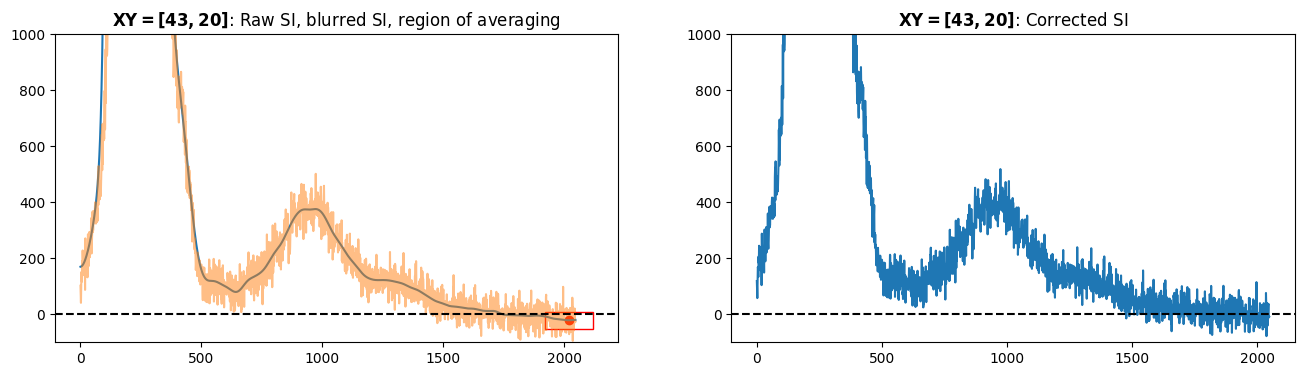

In [ ]:
SI2raw, XY2, disp2, SI2raw_flat = OrganizeInput(filename2)
SI2nc = CorrectNeg(SI2raw, Blur = 20, Neg = -20, Pixrange = 200)
SI2ncflat = SI2nc.reshape((np.prod(XY2),SI2nc.shape[2]))
EnergyAxes2=CalibrateEnergyAxis(SI2nc,disp2)                  # align ZLP & use dispersion to go from pixel -> eV
Eaxflat2=EnergyAxes2.reshape((np.prod(XY2),SI2nc.shape[2]))    # flatten
E2,SI2=CalibrateSI(EnergyAxes2,SI2nc, N = 5000)                # calibrate energies by making all pixels start and end at same energy values
SI2flat=SI2.reshape((np.prod(XY2),SI2.shape[2]))               # flatten


# The two regions are from r1a:r1b  and r2a:r2b
r1a, r1b, r2a, r2b = 0.075, 0.08, 0.17, 0.2

# dataset 2
NBCalc2=np.asarray([[RemoveBackgroundSI2R(E2,s,r1a,r1b,r2a,r2b) for s in row] for row in SI2])
SINB2=NBCalc2[:,:,1,:]
ENB2=NBCalc2[0,0,0,:]
SINB2flat=SINB2.reshape((np.prod(XY2),SINB2.shape[2]))


In [ ]:
haadf2 = '/content/HAADF_FITO0_array_edgewithgap.npy'

ADF2, ADF2scale = LoadADF(haadf2)

# Prepared spectral and structural data:

* SINB ("spectrum image no background") is the hyperspectral data cube,
* ENB ("energy no background") provides the x-axis for the spectra but is technically not needed for subsequent analysis)
* ADF is the purely structural (aligned) image

In [ ]:
input_image = SINB2
energy_axis_ = ENB2
cutoff_energy = 0.2 # cut energies lower than this-- removes effect of silicon nitride phonons

d1, d2, d3 = input_image.shape
X_vec_ = input_image.reshape(d1*d2, d3)

#If normalize
X_vec_ = (X_vec_ - np.min(X_vec_)) / np.ptp(X_vec_)

# energy axis
data = np.copy(input_image)
data_XY = (data.shape[0],data.shape[1])
data_flat = np.reshape(data, (data.shape[0]*data.shape[1], data.shape[2]))

idx = (np.abs(energy_axis_-cutoff_energy)).argmin()
energy_axis = energy_axis_[idx:]

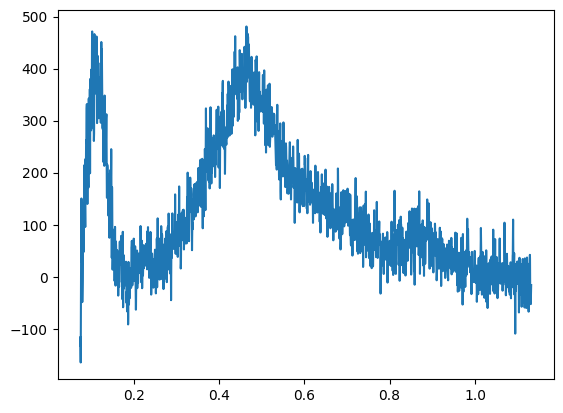

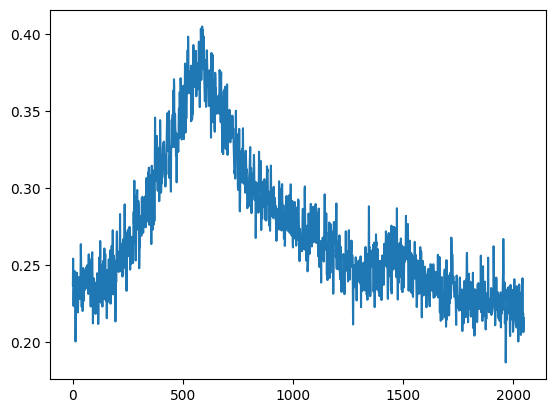

In [ ]:
#If cutoff
d3 = 2048
truncate = np.abs(ENB2-cutoff_energy).argmin()


# # switching this around: never mind....

X_vec = X_vec_[:, truncate:]

# Resample/"Squeeze" the energy axis into 2048 channels
num_ch = 2048

X_vec_resample = np.zeros((X_vec.shape[0], num_ch))
for k in range(X_vec.shape[0]):
  X_vec_resample[k] = signal.resample(X_vec[k], num_ch)

# Put back to original name:

X_vec = np.copy(X_vec_resample)

plt.plot(ENB2,SINB2[0,0])
# plt.axvline(ENB2[502])

plt.figure()
plt.plot(X_vec[0])

# Prepare data for autoencoder

In [ ]:
data = SINB2
energy_axis_ = ENB2
cutoff_energy = 0.2 # cut energies lower than this-- removes effect of silicon nitride phonons


data_XY = (data.shape[0],data.shape[1])
data_flat = np.reshape(data, (data.shape[0]*data.shape[1], data.shape[2]))

idx = (np.abs(energy_axis_-cutoff_energy)).argmin()
energy_axis = energy_axis_[idx:]

In [ ]:
stem_image = ADF2
spectral_image = X_vec.reshape(d1, d2, d3)

window_size = 16  # 16 is default

def MakeWindow(imgsrc, xpos, ypos):
    #Returns the portion of the image within the window given the
    #image (imgsrc), the xposition and the yposition
    imgsrc = imgsrc[int(xpos-window_size/2):int(xpos+window_size/2),
                    int(ypos-window_size/2):int(ypos+window_size/2)]
    return imgsrc

# Array to store images
feature_arr = np.zeros((window_size*window_size))
target_arr = np.zeros((d3))

In [ ]:
# The image crop benchmarking setup

import random
random.seed(42)

# Adjust the following three to get
crop_method = 'sliding'  # sliding/grid/random
sliding_step = 8    # Integer <16 (the window size)
random_size = 2714  # How much random crop performed

if crop_method == 'sliding':
  for i in range(int(window_size/2), int(d1 - window_size/2), sliding_step):
    for j in range(int(window_size/2), int(d2 - window_size/2), sliding_step):
      arr_loc  = MakeWindow(stem_image[:,:], i,j)
      feature_arr = np.column_stack((feature_arr, arr_loc.reshape(window_size*window_size)))
      target_arr = np.column_stack((target_arr, spectral_image[i,j,:]))
elif crop_method == 'grid':
  for i in range(int(window_size/2), int(d1 - window_size/2), window_size):
    for j in range(int(window_size/2), int(d2 - window_size/2), window_size):
      arr_loc  = MakeWindow(stem_image[:,:], i,j)
      feature_arr = np.column_stack((feature_arr, arr_loc.reshape(window_size*window_size)))
      target_arr = np.column_stack((target_arr, spectral_image[i,j,:]))
elif crop_method == 'random':
  for k in range(random_size):
    i = random.randint(int(window_size/2), int(d1 - window_size/2))
    j = random.randint(int(window_size/2), int(d2 - window_size/2))
    arr_loc  = MakeWindow(stem_image[:,:], i,j)
    feature_arr = np.column_stack((feature_arr, arr_loc.reshape(window_size*window_size)))
    target_arr = np.column_stack((target_arr, spectral_image[i,j,:]))
    info_arr = np.column_stack((info_arr, (i,j)))

In [ ]:
print(feature_arr.shape)
print(target_arr.shape)

(256, 49)
(2048, 49)


In [ ]:
# Train-test split before resampling

feature_arr = feature_arr[:, 1:]
target_arr = target_arr[:, 1:]

test_size = int(0.15 * feature_arr.shape[1])

indices = list(range(feature_arr.shape[1]))
random.shuffle(indices)

train_indices = indices[test_size:]
test_indices = indices[:test_size]

X_train = feature_arr[:, train_indices]
y_train = target_arr[:, train_indices]

X_test = feature_arr[:, test_indices]
y_test = target_arr[:, test_indices]

X_test = X_test.T.reshape(-1, window_size, window_size)
y_test = y_test.T

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(256, 41) (2048, 41)
(7, 16, 16) (7, 2048)


In [ ]:
# Resampling to populatae the dataset to the same size

resample_to = 2306  # 85% of 2714

preresample_size = X_train.shape[1]
while X_train.shape[1] < resample_to:
  if resample_to - (X_train.shape[1]) >= preresample_size:
    print('Adding full dataset replica...')
    X_train = np.column_stack((X_train, X_train[:, :preresample_size]))
    y_train = np.column_stack((y_train, y_train[:, :preresample_size]))
  else:
    idx = random.randint(0, preresample_size - 1)
    X_train = np.column_stack((X_train, X_train[:, idx]))
    y_train = np.column_stack((y_train, y_train[:, idx]))

X_train = X_train.T.reshape(-1, window_size, window_size)
y_train = y_train.T
print(X_train.shape)
print(y_train.shape)

Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding full dataset replica...
Adding f

In [ ]:
feature_arr = feature_arr.T.reshape(-1, window_size, window_size)
target_arr = target_arr.T
print(feature_arr.shape)
print(target_arr.shape)

(48, 16, 16)
(48, 2048)


0.19990573775542297 1.1317085079575446 (2048,)
(62, 75)
(62, 75, 2048)


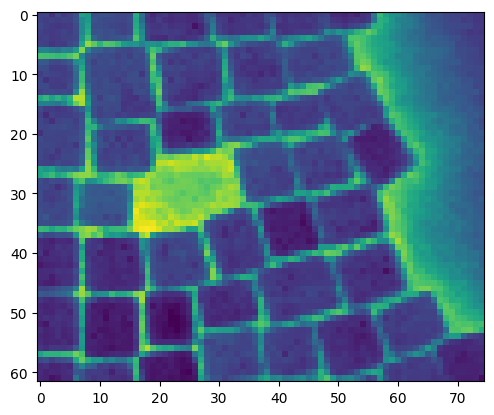

In [ ]:
# Take ADF image
# And spectral data set after cleaning


reshaped_eaxis = np.linspace(energy_axis.min(), energy_axis.max(), num = target_arr.shape[1])

#check it
print(reshaped_eaxis.min(), reshaped_eaxis.max(), reshaped_eaxis.shape)
print(stem_image.shape)
print(spectral_image.shape)

plt.imshow(np.mean(spectral_image[:,:,:],axis=2))

# **PyTorch im2spec**

May 20, 2020

Add PyTorch version made by M. Ziatdinov

In [ ]:
import os
from typing import List, Tuple, Type

import h5py
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [ ]:
def rng_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # for GPU
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
class dilated_block(nn.Module):
    """
    Creates a "pyramid" with dilated convolutional
    layers (aka atrous convolutions)
    """
    def __init__(self, ndim: int, input_channels: int, output_channels: int,
                 dilation_values: List, padding_values: List,
                 kernel_size: int = 3, stride: int = 1, lrelu_a: float = 0.01,
                 use_batchnorm: bool = False, dropout_: float = 0) -> None:
        """
        Initializes module parameters
        """
        super(dilated_block, self).__init__()
        conv_ = nn.Conv1d if ndim < 2 else nn.Conv2d
        atrous_module = []
        for idx, (dil, pad) in enumerate(zip(dilation_values, padding_values)):
            input_channels = output_channels if idx > 0 else input_channels
            atrous_module.append(conv_(input_channels,
                                       output_channels,
                                       kernel_size=kernel_size,
                                       stride=stride,
                                       padding=pad,
                                       dilation=dil,
                                       bias=True))
            if dropout_ > 0:
                atrous_module.append(nn.Dropout(dropout_))
            atrous_module.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                if ndim < 2:
                    atrous_module.append(nn.BatchNorm1d(output_channels))
                else:
                    atrous_module.append(nn.BatchNorm2d(output_channels))
        self.atrous_module = nn.Sequential(*atrous_module)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Forward path
        """
        atrous_layers = []
        for conv_layer in self.atrous_module:
            x = conv_layer(x)
            atrous_layers.append(x.unsqueeze(-1))
        return torch.sum(torch.cat(atrous_layers, dim=-1), dim=-1)


class conv_block(nn.Module):
    """
    Creates block of layers each consisting of convolution operation,
    leaky relu and (optionally) dropout and batch normalization
    """
    def __init__(self, ndim: int, nb_layers: int,
                 input_channels: int, output_channels: int,
                 kernel_size: int = 3, stride: int = 1, padding: int = 1,
                 use_batchnorm: bool = False, lrelu_a: float = 0.01,
                 dropout_: float = 0) -> None:
        """
        Initializes module parameters
        """
        super(conv_block, self).__init__()

        conv_ = nn.Conv1d if ndim < 2 else nn.Conv2d
        block = []
        for idx in range(nb_layers):
            input_channels = output_channels if idx > 0 else input_channels
            block.append(conv_(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
            if dropout_ > 0:
                block.append(nn.Dropout(dropout_))
            block.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                if ndim < 2:
                    block.append(nn.BatchNorm1d(output_channels))
                else:
                    block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward path
        """
        output = self.block(x)
        return output

In [ ]:
class im2spec(nn.Module):
    """
    Encoder (2D) - decoder (1D) type model for generating spectra from image
    """
    def __init__(self,
                 feature_size: Tuple[int, int],
                 target_size: int,
                 latent_dim: int = 10,
                 nb_filters_enc: int = 64,
                 nb_filters_dec: int = 64) -> None:
        super(im2spec, self).__init__()
        self.n, self.m = feature_size
        self.ts = target_size
        self.e_filt = nb_filters_enc
        self.d_filt = nb_filters_dec
        # Encoder params
        self.enc_conv = conv_block(
            ndim=2, nb_layers=3,
            input_channels=1, output_channels=self.e_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.enc_fc = nn.Linear(self.e_filt * self.n * self.m, latent_dim)
        # Decoder params
        self.dec_fc = nn.Linear(latent_dim, self.d_filt*self.ts)
        self.dec_atrous = dilated_block(
            ndim=1, input_channels=self.d_filt, output_channels=self.d_filt,
            dilation_values=[1, 2, 3, 4], padding_values=[1, 2, 3, 4],
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv = conv_block(
            ndim=1, nb_layers=1,
            input_channels=self.d_filt, output_channels=1,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_out = nn.Conv1d(1, 1, 1)

    def encoder(self, features: torch.Tensor) -> torch.Tensor:
        """
        The encoder embeddes the input image into a latent vector
        """
        x = self.enc_conv(features)
        x = x.reshape(-1, self.e_filt * self.m * self.n)
        return self.enc_fc(x)

    def decoder(self, encoded: torch.Tensor) -> torch.Tensor:
        """
        The decoder generates 1D signal from the embedded features
        """
        x = self.dec_fc(encoded)
        x = x.reshape(-1, self.d_filt, self.ts)
        x = self.dec_atrous(x)
        x = self.dec_conv(x)
        return self.dec_out(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward model"""
        encoded = self.encoder(x)
        return self.decoder(encoded)

In [ ]:
X_train = torch.from_numpy(X_train[:, None, ...]).float()
y_train = torch.from_numpy(y_train[:, None, ...]).float()
X_test = torch.from_numpy(X_test[:, None, ...]).float()
y_test = torch.from_numpy(y_test[:, None, ...]).float()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2306, 1, 16, 16]) torch.Size([2306, 1, 2048])
torch.Size([7, 1, 16, 16]) torch.Size([7, 1, 2048])


In [ ]:
minibatch_size = 64
use_gpu = torch.cuda.is_available()

# Prepare data
if isinstance(X_train, np.ndarray):
    tor = lambda x: torch.from_numpy(x).float()
    X_train, X_test = tor(X_train), tor(X_test)
    y_train, y_test = tor(y_train), tor(y_test)

# Transfer to GPU device if available
if use_gpu:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

# Initialize dataloader
data_train = torch.utils.data.TensorDataset(X_train, y_train)
data_test = torch.utils.data.TensorDataset(X_test, y_test)
train_iterator = torch.utils.data.DataLoader(
    data_train, batch_size=minibatch_size, shuffle=True)
test_iterator = torch.utils.data.DataLoader(data_test, batch_size=minibatch_size)

In [ ]:
num_epochs = 30 # number of training epochs
latent_dim = 10 # number of latent dimensions
feature_size = (16, 16)
target_size = 2048
rng_seed(1) # for reproducibility

# Initialize model
ed = im2spec(feature_size, target_size, latent_dim)

if use_gpu:
    torch.cuda.empty_cache()
    ed.cuda()

# Specify optimizer and loss criterion
optimizer = torch.optim.Adam(ed.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_losses = []
test_losses = []

# Model training
for e in range(num_epochs):
    c, c_test = 0, 0
    losses, losses_test = 0, 0
    ed.train()
    for feature, target in train_iterator:
        b = feature.size(0)
        y_predicted = ed.forward(feature)
        loss = criterion(y_predicted, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses += loss.item()
        c += b
    else:
        ed.eval()
        with torch.no_grad():
            for feature, target in test_iterator:
                b = feature.size(0)
                y_predicted = ed.forward(feature)
                loss = criterion(y_predicted, target)
                losses_test += loss.item()
                c_test += b
    train_losses.append(losses / c)
    test_losses.append(losses_test / c_test)
    print('Epoch: {}... Training loss: {}... Test loss: {}'.format(
        e, np.round(train_losses[-1], 7), np.round(test_losses[-1], 7)))

ed.cpu()
X_test, y_test = X_test.cpu(), y_test.cpu()
X_train, y_train = X_train.cpu(), y_train.cpu()

Epoch: 0... Training loss: 0.0060777... Test loss: 0.011681
Epoch: 1... Training loss: 0.0045857... Test loss: 0.0228012
Epoch: 2... Training loss: 0.0036204... Test loss: 0.0243984
Epoch: 3... Training loss: 0.0028697... Test loss: 0.0205056
Epoch: 4... Training loss: 0.0022947... Test loss: 0.0154683
Epoch: 5... Training loss: 0.0018342... Test loss: 0.0116708
Epoch: 6... Training loss: 0.0014799... Test loss: 0.0108672
Epoch: 7... Training loss: 0.0011876... Test loss: 0.0086989
Epoch: 8... Training loss: 0.0009455... Test loss: 0.0068022
Epoch: 9... Training loss: 0.0007505... Test loss: 0.0050422


Save trained model:

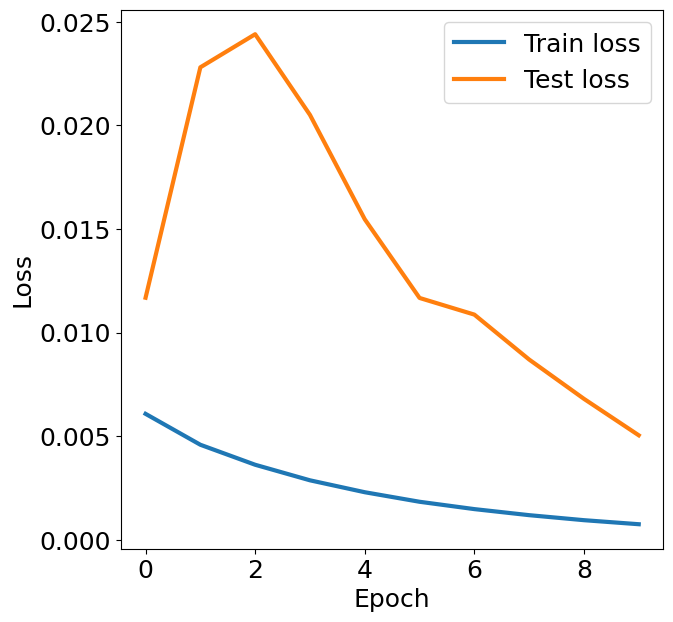

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(train_losses, linewidth=3)
plt.plot(test_losses, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train loss', 'Test loss'], loc='upper right', fontsize=18)
plt.show()

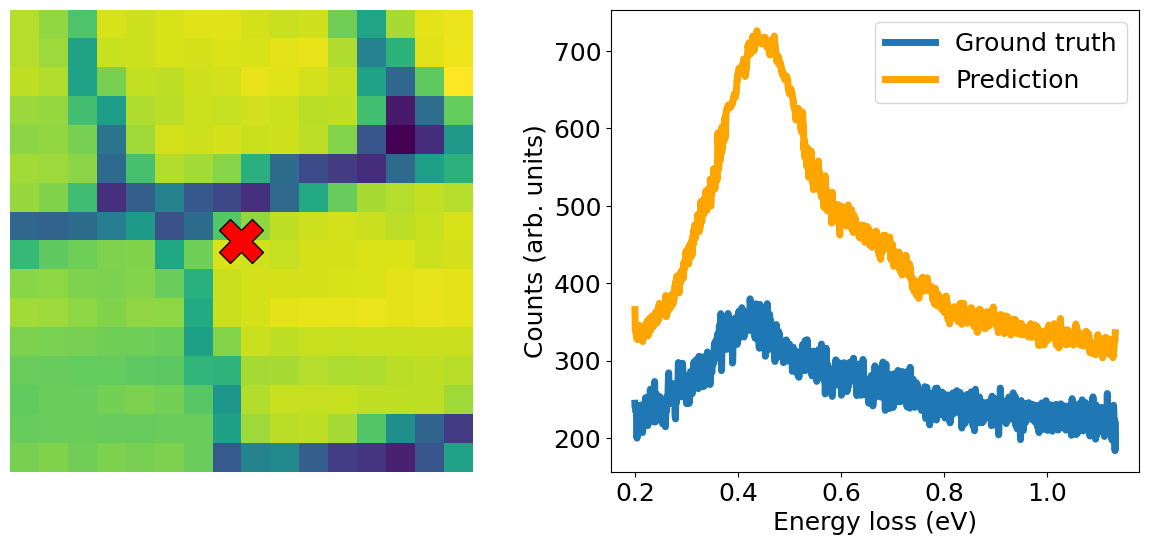

In [ ]:
k = 0 # number of image from validation set for testing

# Make prediction
with torch.no_grad():
    prediction = ed.cpu().forward(X_test[k:k+1])

# Plot results
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(X_test[k, 0])
ax1.axis(False)
ax2.plot(reshaped_eaxis,1000*y_test[k, 0], linewidth=5, label='Ground truth')
ax2.plot(reshaped_eaxis,1000*prediction[0, 0], linewidth=5, color='orange', label='Prediction')
ax2.set_xlabel("Energy loss (eV)", fontsize=18)
ax2.set_ylabel("Counts (arb. units)", fontsize=18)
#ax2.set_ylim(-8.5, 8)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax2.legend(fontsize=18, loc='upper right')

ax1.scatter(7.5,7.5,marker = 'X', c='r', s = 1000, edgecolors = 'k')

In [ ]:
# Full feature array for ploting
feature_arr = np.zeros((window_size*window_size))
target_arr = np.zeros((d3))
info_arr= np.zeros((2))

for i in range(int(window_size/2), int(d1 - window_size/2)):
  for j in range(int(window_size/2), int(d2 - window_size/2)):
    arr_loc  = MakeWindow(stem_image[:,:], i,j)
    feature_arr = np.column_stack((feature_arr, arr_loc.reshape(window_size*window_size)))
    target_arr = np.column_stack((target_arr, spectral_image[i,j,:]))
    info_arr = np.column_stack((info_arr, (i,j)))

info_arr = info_arr[:, 1:].T
feature_arr = feature_arr[:, 1:].T.reshape(-1, window_size, window_size)
target_arr = target_arr[:, 1:].T

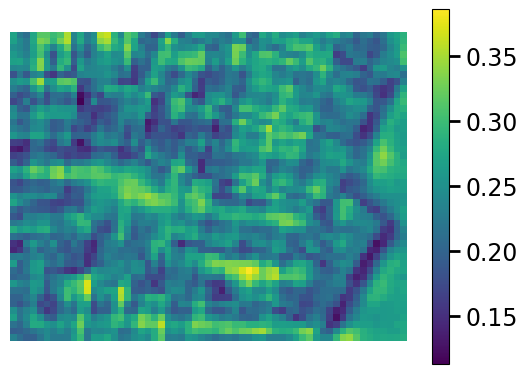

In [ ]:
# This tends to crash Colab. Run last

def batch_predict(features: np.ndarray, model: Type[nn.Module],
                  target_size: int, num_batches: int = 10) -> np.ndarray:

    features = torch.from_numpy(features[:, None, ...]).float()
    if torch.cuda.is_available():
        model.cuda()
        features = features.cuda()
    batch_size = len(features) // num_batches
    predictions = np.zeros((len(features), 1, target_size))
    for i in range(num_batches):
        if i == num_batches - 1:
            fbatch = features[i*batch_size:]
        else:
            fbatch = features[i*batch_size:(i+1)*batch_size]
        with torch.no_grad():
            pred_i = model.forward(fbatch)
        if i == num_batches - 1:
            predictions[i*batch_size:] = pred_i.cpu().numpy()
        else:
            predictions[i*batch_size:(i+1)*batch_size] = pred_i.cpu().numpy()
    return predictions


pred_loop = batch_predict(feature_arr, ed, target_size)
pred_loop = pred_loop[:, 0, :]
error = (np.mean((pred_loop-target_arr)**2,axis = 1) /
         np.mean((pred_loop+target_arr)**2,axis = 1))**(1/2)
plt.imshow(error.reshape(d1-window_size,d2-window_size), origin = 'lower')
# plt.colorbar(shrink = 0.8, format = '%.2f');
cbar = plt.colorbar(shrink = 0.96, format = '%.2f');
plt.axis('off')
cbar.ax.tick_params(labelsize=17, width = 2, length = 8)

* Calculate MEAN of error of entire image:

In [ ]:
np.mean(error)

0.23884866572977112